In [3]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset, split_train_val, prepare_test_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import pickle

In [4]:
# Enable the widgets extension for JupyterLab
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-labextension` not found.


In [5]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [6]:
# Global variables

# Define the class names for the medical conditions
class_names = ['Pleural Effusion']

# Define the policies for dataset preparation
policies = ['ones', 'zeroes', 'mixed']

#### Constructing training dataset

In [7]:
# Import the train dataset
original_train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')

# # Prepare the dataset using the last policy in the list and the defined class names
# image_paths, label_matrix = prepare_dataset(original_train_df, policies[-1], class_names)

# # Create a DataFrame for the image paths
# image_paths_df = pd.DataFrame({'path': image_paths})

# # Create a DataFrame for the labels with the class names as columns
# labels_df = pd.DataFrame(label_matrix, columns=class_names)

# # Combine the image paths DataFrame and the labels DataFrame
# original_train_df = pd.concat([image_paths_df, labels_df], axis=1)

# Split the original training data into separate training 
# and validation sets while preserving the original 
# validation test set as the final test set.
train_df, validation_df = split_train_val(original_train_df, policies[-1], class_names)

In [8]:
train_df

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient43609/study1/...,0
1,CheXpert-v1.0-small/train/patient09753/study3/...,0
2,CheXpert-v1.0-small/train/patient24226/study1/...,1
3,CheXpert-v1.0-small/train/patient01545/study19...,1
4,CheXpert-v1.0-small/train/patient34656/study4/...,1
...,...,...
152816,CheXpert-v1.0-small/train/patient14081/study2/...,0
152817,CheXpert-v1.0-small/train/patient12908/study1/...,0
152818,CheXpert-v1.0-small/train/patient35602/study6/...,0
152819,CheXpert-v1.0-small/train/patient04455/study1/...,0


In [9]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
display(train_df.head())
print(f"The original training dataset contains {original_train_df.shape[0]} samples.")
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient43609/study1/...,0
1,CheXpert-v1.0-small/train/patient09753/study3/...,0
2,CheXpert-v1.0-small/train/patient24226/study1/...,1
3,CheXpert-v1.0-small/train/patient01545/study19...,1
4,CheXpert-v1.0-small/train/patient34656/study4/...,1


The original training dataset contains 223414 samples.
Number of rows and columns in the train DataFrame: (152821, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object


In [10]:
# Print some information about the validtion DataFrame
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
display(validation_df.head())
print(f"The original training dataset contains {original_train_df.shape[0]} samples.")
print("Number of rows and columns in the validation DataFrame:", validation_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(validation_df.dtypes)

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient30642/study3/...,0
1,CheXpert-v1.0-small/train/patient47165/study1/...,0
2,CheXpert-v1.0-small/train/patient48106/study4/...,0
3,CheXpert-v1.0-small/train/patient35473/study1/...,0
4,CheXpert-v1.0-small/train/patient40872/study1/...,1


The original training dataset contains 223414 samples.
Number of rows and columns in the validation DataFrame: (38206, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object


#### Constructing validation dataset

In [11]:
# Import the validation dataset as final test set
test_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Prepare the test dataset using the last policy in the list and the defined class names
test_image_paths, test_label_matrix = prepare_dataset(test_df, policies[-1], class_names)

# Create a DataFrame for the test image paths
test_image_paths_df = pd.DataFrame({'path': test_image_paths})

# Create a DataFrame for the test labels with the class names as columns
test_labels_df = pd.DataFrame(test_label_matrix, columns=class_names)

# Combine the test image paths DataFrame and the test labels DataFrame
test_df = pd.concat([test_image_paths_df, test_labels_df], axis=1)

In [12]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(test_df.head())
print("Number of rows and columns in the test DataFrame:", test_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(test_df.dtypes)

,path,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64735/study1/...,0
1,CheXpert-v1.0-small/valid/patient64634/study1/...,0
2,CheXpert-v1.0-small/valid/patient64712/study1/...,0
3,CheXpert-v1.0-small/valid/patient64662/study1/...,0
4,CheXpert-v1.0-small/valid/patient64578/study1/...,0


Number of rows and columns in the test DataFrame: (202, 2)
Column names and data types:
path                object
Pleural Effusion     int64
dtype: object


#### Dataset formation according to torch (using dataloaders)

In [13]:
# Define the transformation pipeline for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Define the class names for the medical conditions
class_names = ['Pleural Effusion']

# Create the training dataset with the defined transformations
train_dataset = CheXpertDataset(train_df, class_names, transform=transform)

# Create the validation dataset with the defined transformations
valid_dataset = CheXpertDataset(validation_df, class_names, transform=transform)

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create DataLoader for the validation dataset
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Verify data loading by fetching a batch of images and labels from the training DataLoader
images, labels = next(iter(train_loader))

#### Visualising example

In [14]:
# Fetch a batch of images and labels from the validation DataLoader
# test_X contains the images and test_Y contains the
# corresponding labels from the validation set
test_X, test_Y = next(iter(valid_loader))

Original shape: torch.Size([3, 224, 224]), New shape: (224, 224, 3)
Example image:


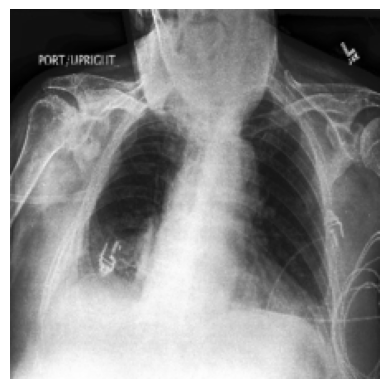

In [15]:
# Select the first image in the batch
image = test_X[0]
original_shape = image.shape
image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224, 3)
new_shape = image.shape
print(f"Original shape: {original_shape}, New shape: {new_shape}")
# Check the shape of the image to ensure it is (224, 224, 3)
assert new_shape == (224, 224, 3), f"Expected shape (224, 224, 3), but got {image.shape}"

# Denormalize the image for visualization
image = (image * 0.5) + 0.5

# Plot the image
print("Example image:")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

#### Here we can extract different pre-trained models (in the given example, Resnet18 and vision transformer).

In [16]:
# Load a pre-trained ResNet-18 model, add custom layers, and freeze certain layers
# 
# Parameters:
# - pretrained: Use a pre-trained version of ResNet-18
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_resnet = upload_pretrained(resnet18, add_layers=True, n_labels=len(class_names), freeze_layers=True)
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Move the model to the appropriate device
model_resnet.to(device)

Using device: cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Inception 

In [22]:
model_inception = upload_pretrained(models.inception_v3(pretrained=True), add_layers=True, n_labels=1, freeze_layers=True) # Assuming 8 output classes


In [28]:
summary(model_inception, input_size=(3, 224, 224))

RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

##### Moreover, we can see summary of a model

In [25]:
# Display the model summary
summary(model_resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [30]:
# Initialize the model
model_densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Add custom layers
densenet121 = upload_pretrained_densenet121(model_densenet121, add_layers=True, n_labels=len(class_names), freeze_layers=True)

# Verify it's a proper PyTorch model
print(isinstance(densenet121, nn.Module))

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet121 = densenet121.to(device)

# Try summary with explicit tensor creation
from torchsummary import summary
summary(densenet121.cpu(), input_size=(3, 224, 224))

True


AttributeError: 'list' object has no attribute 'size'

In [32]:
model = models.densenet121(pretrained=True)

/opt/anaconda3/envs/xai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/xai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
import torch
print(torch.__version__)  
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0
None
None
False


#### Here is how we train the model

In [24]:

# Define the loss function
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
# Adam optimizer with learning rate of 0.001
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

# Check if GPU is available and use it if possible, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
# Parameters:
# - model: The model to be trained (ResNet-18 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - save_filename: Filename to save the trained model
train_losses_resnet, train_accuracies_resnet, test_losses_resnet, test_accuracies_resnet = train_model(
    model=densenet121,
    train_loader=train_loader,
    test_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer_resnet,
    num_epochs=20,
    device=device,
    save_filename='model_resnet.pth'
)

Epoch 1/20:   0%|          | 0/4776 [00:00<?, ?batch/s]

AttributeError: 'list' object has no attribute 'size'

### Pickle the trained model

In [56]:
with open('model_resnet.pkl', 'rb') as f:
    loaded_model_resnet = pickle.load(f)

print("Model loaded from model_resnet.pkl")

### Load the trained model

In [30]:
with open('model_resnet.pkl', 'rb') as f:
    loaded_model_resnet = pickle.load(f)

print("Model loaded from model_resnet.pkl")

Existing classes in test_df: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
Test Labels (Filtered):
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 ...
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Test Predictions (Filtered):
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ...
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Confusion Matrix for Atelectasis:
[[127   0]
 [ 75   0]]
Confusion Matrix for Cardiomegaly:
[[136   0]
 [ 66   0]]
Confusion Matrix for Consolidation:
[[170   0]
 [ 32   0]]
Confusion Matrix for Edema:
[[160   0]
 [ 42   0]]
Confusion Matrix for Pleural Effusion:
[[118  20]
 [ 39  25]]


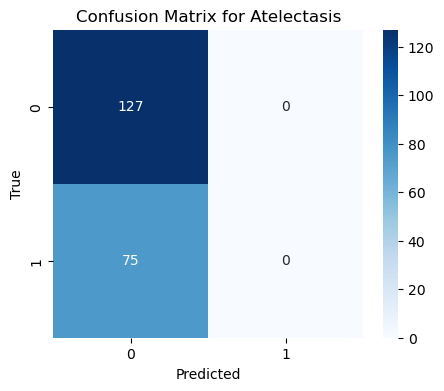

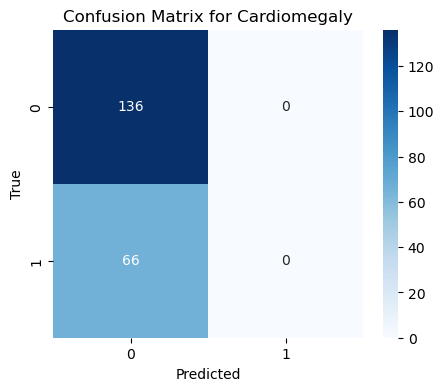

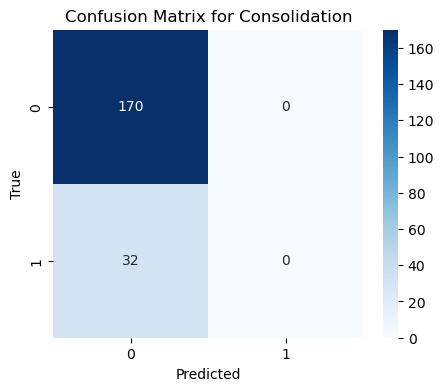

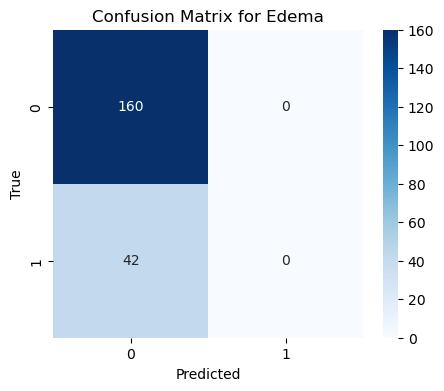

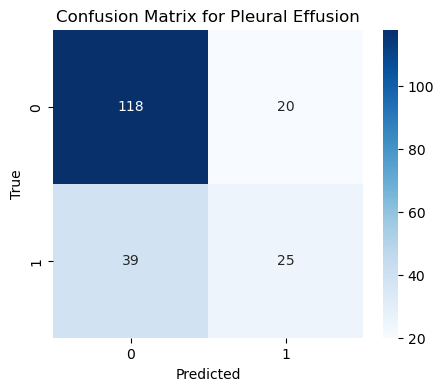

Accuracy: 0.3564
F1 Scores:
              Class  F1 Score
0       Atelectasis  0.000000
1      Cardiomegaly  0.000000
2     Consolidation  0.000000
3             Edema  0.000000
4  Pleural Effusion  0.458716
Precision Scores:
              Class  Precision
0       Atelectasis   0.000000
1      Cardiomegaly   0.000000
2     Consolidation   0.000000
3             Edema   0.000000
4  Pleural Effusion   0.555556
Recall Scores:
              Class    Recall
0       Atelectasis  0.000000
1      Cardiomegaly  0.000000
2     Consolidation  0.000000
3             Edema  0.000000
4  Pleural Effusion  0.390625


In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

# Function to evaluate the model on the test dataset
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Create the test dataset with the defined transformations
test_dataset = CheXpertDataset(test_df, class_names, transform=transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test dataset
test_preds, test_labels = evaluate_model(loaded_model_resnet, test_loader, device)

# Binarize the predictions
test_preds_binary = (test_preds > 0.5).astype(int)

# Check which classes exist in test_df
existing_classes_indices = [i for i in range(len(class_names)) if test_labels[:, i].sum() > 0]
existing_classes = [class_names[i] for i in existing_classes_indices]
print("Existing classes in test_df:", existing_classes)

# Filter the predictions and labels to only include existing classes
test_preds_binary_filtered = test_preds_binary[:, existing_classes_indices]
test_labels_filtered = test_labels[:, existing_classes_indices]

# Debugging information
print("Test Labels (Filtered):")
print(test_labels_filtered)
print("Test Predictions (Filtered):")
print(test_preds_binary_filtered)

# Calculate F1 scores
f1_scores = f1_score(test_labels_filtered, test_preds_binary_filtered, average=None, zero_division=0)
f1_scores_df = pd.DataFrame({'Class': existing_classes, 'F1 Score': f1_scores})

# Calculate precision scores
precision_scores = precision_score(test_labels_filtered, test_preds_binary_filtered, average=None, zero_division=0)
precision_scores_df = pd.DataFrame({'Class': existing_classes, 'Precision': precision_scores})

# Calculate recall scores
recall_scores = recall_score(test_labels_filtered, test_preds_binary_filtered, average=None, zero_division=0)
recall_scores_df = pd.DataFrame({'Class': existing_classes, 'Recall': recall_scores})

# Calculate accuracy
accuracy = accuracy_score(test_labels_filtered, test_preds_binary_filtered)

# Calculate confusion matrix for each class
conf_matrices = []
for i, class_name in enumerate(existing_classes):
    conf_matrix = confusion_matrix(test_labels_filtered[:, i], test_preds_binary_filtered[:, i])
    conf_matrices.append(conf_matrix)
    print(f"Confusion Matrix for {class_name}:\n{conf_matrix}")

# Classification report
class_report = classification_report(test_labels_filtered, test_preds_binary_filtered, target_names=existing_classes, output_dict=True, zero_division=0)
class_report_df = pd.DataFrame(class_report).transpose()

# Save F1 scores to CSV
f1_scores_df.to_csv('f1_scores.csv', index=False)

# Save precision scores to CSV
precision_scores_df.to_csv('precision_scores.csv', index=False)

# Save recall scores to CSV
recall_scores_df.to_csv('recall_scores.csv', index=False)

# Save classification report to CSV
class_report_df.to_csv('classification_report.csv')

# Plot confusion matrix for each class
for i, class_name in enumerate(existing_classes):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Print additional evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Scores:\n{f1_scores_df}")
print(f"Precision Scores:\n{precision_scores_df}")
print(f"Recall Scores:\n{recall_scores_df}")